# Mini-project Time Series

In this notebook we experiment the use of Empirical Mode Decomposition (EMD) for signal denoising and detrending as proposed in the paper *Detrending And Denoising With Empirical Mode Decompositions* by Patrick Flandrin, Paulo Gonçalvès,  Gabriel Rilling. 

## Basics of empirical mode decomposition

Historically the Fourier spectral analysis is the standard for signal decomposition and analysis. However, this method is only valid for **linear** and **stationary data**, which is rarely the case for real physical data. Non-stationarity and nonlinearity will therefore induce spurious harmonic components that cause energy spreading, which leads to energy-frequency distributions which make little physical sense for this type of data.

The Empirical Mode Decomposition (EMD) was introduced in *The empirical mode decomposition and the Hilbert spectrum for nonlinear and non-stationary time series analysis* by Norden Huang in 1998. The main motivation behind the EMD is to decompose a signal into a collection of intrinsic mode functions (IMF) which forms a complete and almost orthogonal basis. The definition of the IMF is to that they have well-behaved Hilbert transforms. This gives a full energy-frequency-time distribution of the data which is ideal for nonlinear and non-stationary data analysis. 

The key idea behind EMD is to analyze oscillations at a local level, capturing the signal's behavior between consecutive extrema (minima and maxima). We implemented the following EMD algorithm in the next cell.

**Input:** Signal $x(t)$  
**Output:** IMFs $\text{IMF}_i(t)$ and residual $r(t)$  
**Initialize:** $r(t) = x(t)$, $i = 1$

---

#### **EMD Algorithm**

1. **While** $r(t)$ does not satisfy *END conditions*:
   1. **Step 1:** Identify all local minima and maxima of $r(t)$.
   2. **Step 2:** Interpolate between local minima and maxima to create the lower and upper envelopes $e_{\text{min}}(t)$ and $e_{\text{max}}(t)$.
   3. **Step 3:** Compute the mean envelope:
      $$
      m(t) = \frac{e_{\text{min}}(t) + e_{\text{max}}(t)}{2}.
      $$
   4. **Step 4:** Compute the detail:
      $$
      d(t) = r(t) - m(t).
      $$
   5. **Step 5: Sifting Process**
      - **If** $d(t)$ does not satisfy *IMF conditions*:
        - Set $r(t) = d(t)$ and repeat Steps 1–4.
      - **Else:**
        - Save $d(t)$ as $\text{IMF}_i(t)$.
        - Update the residual:
          $$
          r(t) \leftarrow r(t) - \text{IMF}_i(t).
          $$
        - Increment $ i \leftarrow i + 1 $.

---

### **Final Decomposition**

The signal $ x(t) $ is decomposed as:
$$
x(t) = \sum_{i=1}^n \text{IMF}_i(t) + r(t),
$$
where:
- $ \text{IMF}_i(t) $ are the Intrinsic Mode Functions (IMFs).
- $ r(t) $ is the final residual.

## Implementation of EMD algorithm

Our first goal is to implement a simple and efficient version of the EMD algorithm. There exists several algorithm variations that have been proposed since 1998 for the three parts :
- choice of end criterion for sifting : nb zeros / Rilling / SD / max sifting iter
- choice of end criterion for global EMD : max IMF / reach trend / total power threshold
- choice of interpolation to build enveloppes : we chose cubic spline as explained in https://perso.ens-lyon.fr/patrick.flandrin/NSIP03.pdf ("other types of interpolation (linear or polynomial) tend to increase the required number of sifting iterations and to “over-decompose” signals by spreading out their components over adjacent modes") + issue of boundary conditions so my mirro the extrema close to the edges.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import sawtooth, spectrogram

from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.optimize import curve_fit

import librosa
import IPython.display as ipd
import pywt

plt.style.use('default')
plt.rcParams["text.usetex"] = True

from denoisemd import EMD # Our implementation of the EMD

Firstly, we test the EMD decomposition on the following signal:

$$S(T) = S_{\text{original}}(T) + S_{\text{noise}}(T)$$


which contains an original signal $$S_{\text{original}}(T) = T^2 + \sin(13T)$$


and a frequency-modulated term:

$$S_{\text{noise}}(T) = \sin\left(20T \cdot (1 + 0.2T)\right)$$

The three terms are separated into three IMFs.

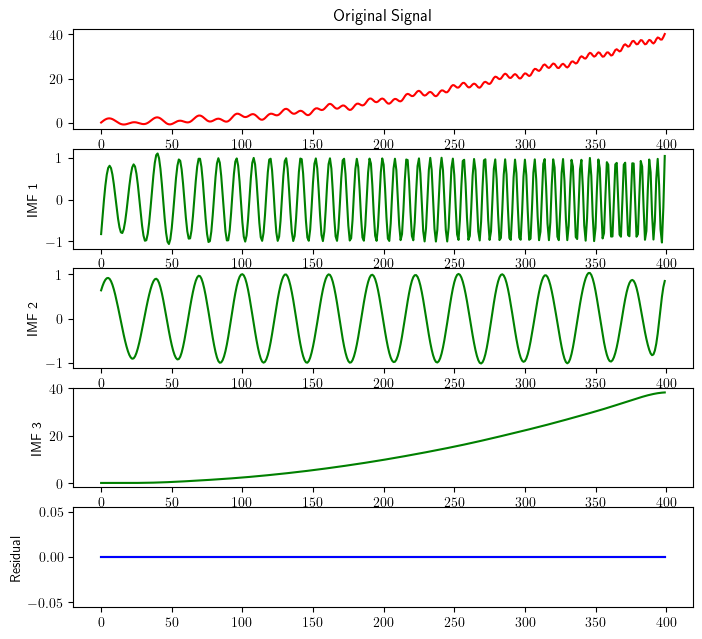

In [23]:
N = 400
T = np.linspace(0, 2*np.pi, N)
S_original = T**2 + np.sin(13 * T)
S = S_original + np.sin(20 * T * (1 + 0.2 * T))

emd = EMD()

imfs, residual = emd.decompose(S)
emd.plot_decomp(S, imfs, residual)

We then test the EMD decomposition on the following signal:


$$S(t) = S_1(t) + S_2(t) + S_{noise}(t)$$

which contains a large triangular wave: $$S_1(t) = \text{sawtooth}(6\pi t, 0.5)$$

A smaller, high-frequency triangular wave: $$S_2(t) = 0.2 \cdot \text{sawtooth}(160\pi t, 0.5)$$

And a sinusoidal wave: $$S_{noise}(t) = 0.4 \cdot \sin(50\pi t)$$

These three terms are retrieved in the first three IMFs.

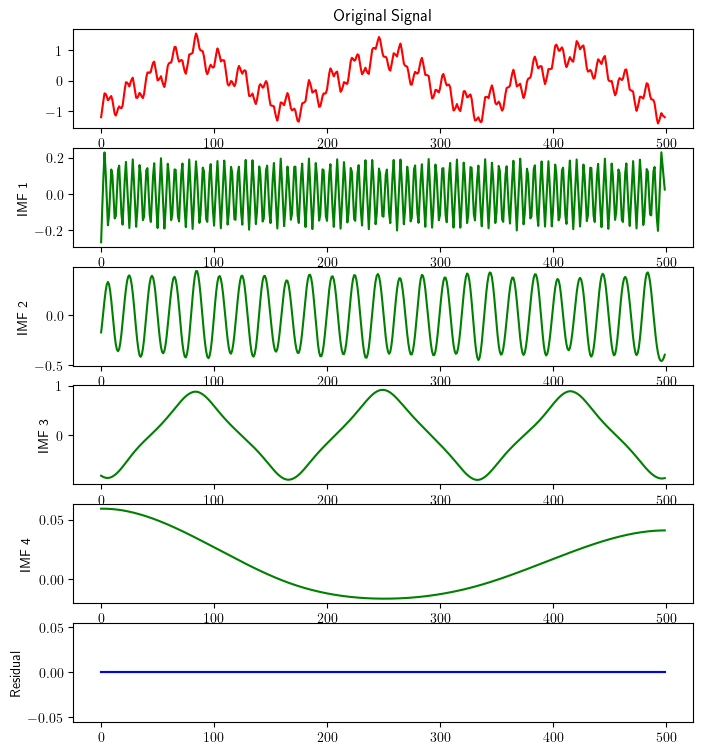

In [24]:
t = np.linspace(0, 1, 500)
triangle_big = sawtooth(2 * np.pi * 3 * t, 0.5)
triangle_small = 0.2 * sawtooth(2 * np.pi * 80 * t, 0.5)
sinusoid = 0.4*np.sin(5 * np.pi * 10 * t)
s = triangle_big + triangle_small + sinusoid

emd = EMD()

imfs, residual = emd.decompose(s)
emd.plot_decomp(s, imfs, residual)

Finally, we test the EMD decomposition on the following signal:


$$S(t) = S_1(t) + S_2(t) + S_{\text{wavepacket}}(t)$$


which contains a frequency-modulated (FM) signal with a high modulation index:

$$S_1(t) = \sin(2\pi f_{\text{carrier1}} t + \beta_1 \cdot \sin(2\pi f_{\text{mod}} t))$$

where $f_{\text{carrier1}} = 500 Hz$, $f_{\text{mod}} = 2 Hz$, and $\beta_1 = 70$.

A frequency-modulated (FM) signal with a lower modulation index:

$$S_2(t) = \sin(2\pi f_{\text{carrier2}} t + \beta_2 \cdot \sin(2\pi f_{\text{mod}} t))$$

where $f_{\text{carrier2}} = 300 Hz$, $f_{\text{mod}} = 2 Hz$, and $\beta_2 = 30$.

And a Gaussian wavepacket:

$$S_{\text{wavepacket}}(t) = \exp\left(-\frac{(t - t_0)^2}{2\sigma^2}\right) \cdot \sin(2\pi f_{\text{carrier3}} t)$$

where the Gaussian envelope is centered at $t_0 = 0.5 s$ with a standard deviation of $\sigma = 0.05 s$, and $f_{\text{carrier3}} = 100 Hz$.

The combination of these three components creates a complex signal that contains both frequency modulation and time-localized oscillations.

Once again, these three terms are retrieved in the first three IMFs.

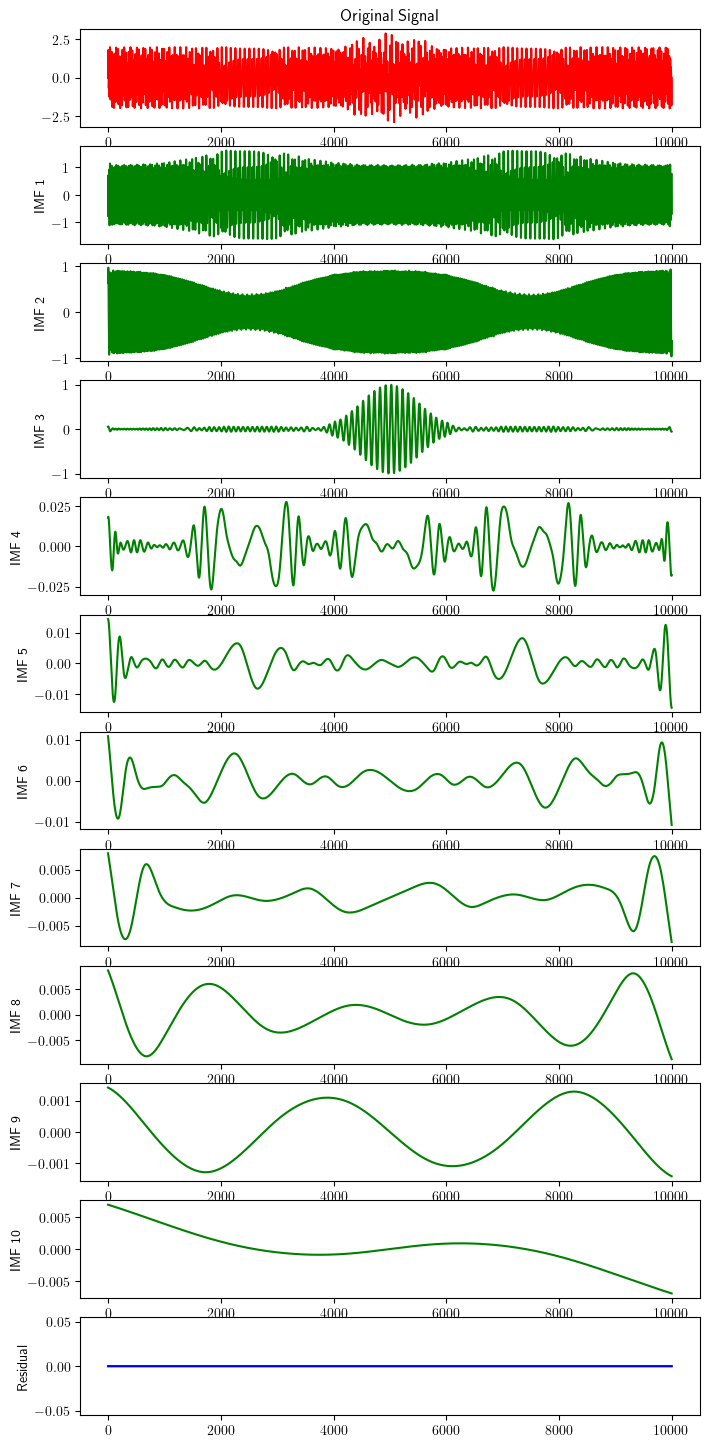

In [40]:
# Create FM and Gaussian wavepacket signals
def make_fm_signal(fs, T, f_carrier, f_mod, beta):
    t = np.linspace(0, T, fs * T)
    mod_signal = np.sin(2 * np.pi * f_mod * t)
    fm_signal = np.sin(2 * np.pi * f_carrier * t + beta * mod_signal)
    return t, fm_signal

def make_gaussian_wp(fs, T, t0, sigma, f_carrier):
    t = np.linspace(0, T, fs * T)
    gaussian_envelope = np.exp(-((t - t0)**2) / (2 * sigma**2))
    carrier_wave = np.sin(2 * np.pi * f_carrier * t)
    wavepacket = gaussian_envelope * carrier_wave
    return t, wavepacket

fs = 10000
T = 1
t, fm_1 = make_fm_signal(fs, T, 500, 2, 70)
_, fm_2 = make_fm_signal(fs, T, 300, 2, 30)
_, gaussian_wp = make_gaussian_wp(fs, T, 0.5, 0.05, 100)


full_signal = fm_1 + fm_2 + gaussian_wp

emd = EMD()
imfs, residual = emd.decompose(full_signal)
emd.plot_decomp(full_signal, imfs, residual)

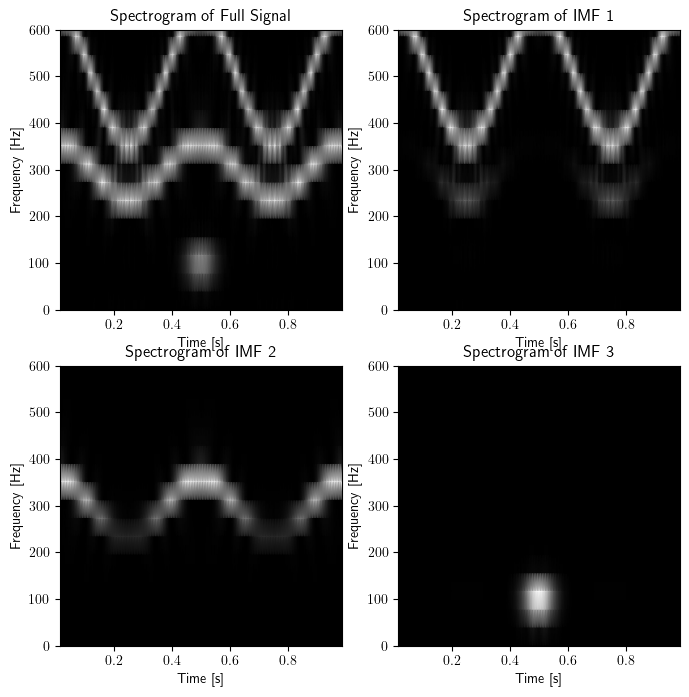

In [41]:
def plot_spectrogram(signal, fs, title, ax):
    f, time, Sxx = spectrogram(signal, fs=fs, nperseg=256, noverlap=200)
    ax.pcolormesh(time, f, Sxx, shading='gouraud', cmap='gray')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [s]')
    ax.set_title(title)
    ax.set_ylim(0, 600)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

plot_spectrogram(full_signal, fs, "Spectrogram of Full Signal", axes[0, 0])

for i in range(3):
    plot_spectrogram(imfs[i], fs, f"Spectrogram of IMF {i+1}", axes[(i+1)//2, (i+1)%2])

plt.show()

## Detrending

In this section, we apply a detrending method based on the standardized empirical mean of the fine-to-coarse EMD reconstruction. The method assumes that the signal consists of slowly varying trends and fluctuating processes.

The detrended signal is reconstructed by summing the IMFs starting from the largest index that is not contaminated by the trend. To identify this index:

1. We compute the standardized empirical mean $\sum_{k=1}^{D} IMF_k(t)$ for each partial reconstruction


2. The reconstruction stops when the standardized mean deviates quantitatively from zero, indicating contamination by the trend.

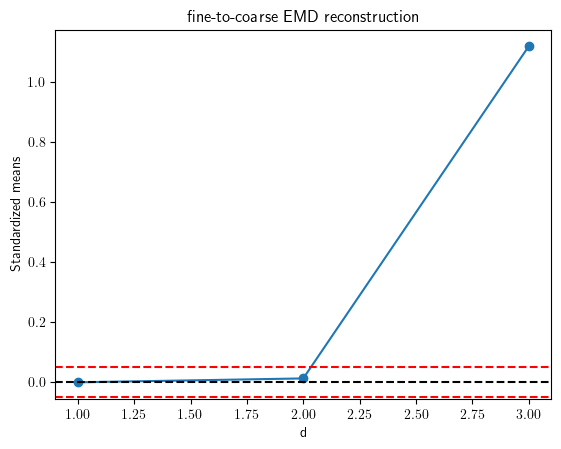

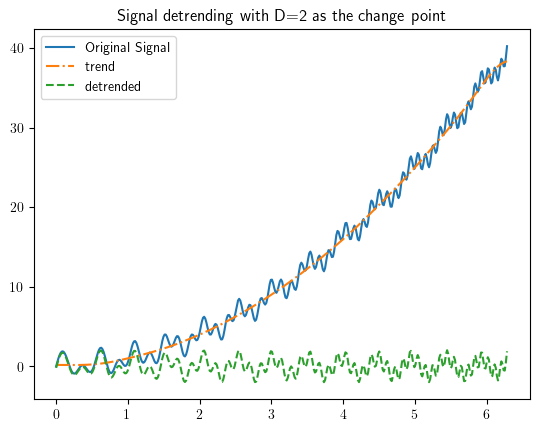

In [42]:
N = 400
T = np.linspace(0, 2*np.pi, N)
S_original = T**2 + np.sin(13 * T)
S = S_original + np.sin(20 * T * (1 + 0.2 * T))
imfs, residual = emd.decompose(S)
emd.detrend(T, S, imfs, residual, 0.05)

However, this method doesn't work well on all signals. Indeed, one can find a signal where pretty much all the IMFs are symmetric, leading to no trend detection.

It's the case for the following signal, where the trend is only made by the residual which is null.

$$S(t) = S_{\text{original}}(t) + \text{fGn}(t)$$

Where we have a modulated sinusoidal wave with frequencies  $f_1 = 5 Hz$ and $f_2 = 0.5 Hz$:

$$S_{\text{original}}(t) = \sin(2\pi f_1 t) \cdot \sin(2\pi f_2 t)$$

And a Fractional Gaussian Noise $\text{fGn}(t)$ generated using a Hurst exponent $H = 0.3$. 

In [43]:
!pip install stochastic
from stochastic.processes.noise import FractionalGaussianNoise


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


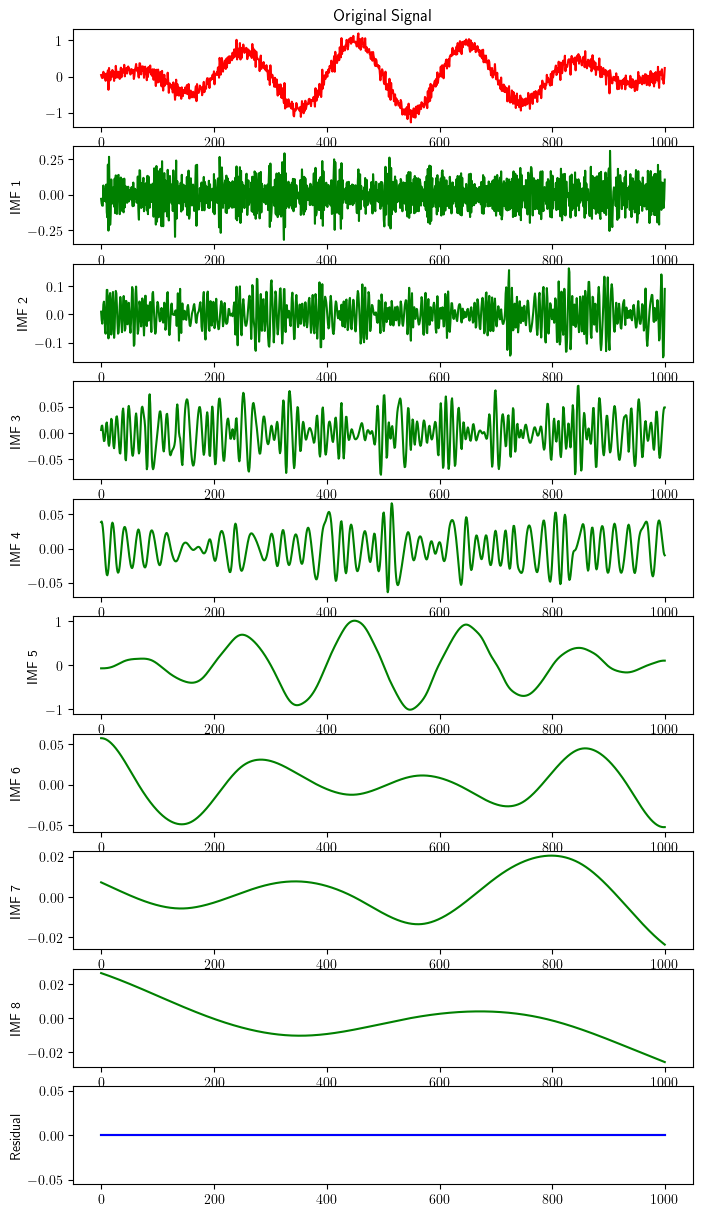

In [44]:
H = 0.3  # Hurst exponent
N = 1000
T = np.linspace(0, 1, N)
fGn = FractionalGaussianNoise(hurst=H).sample(N)

f1 = 5
f2 = 0.5
S_original = np.sin(2 * np.pi * f1 * T) * np.sin(2 * np.pi * f2 * T) 
S = S_original + fGn
imfs, residual = emd.decompose(S)
emd.plot_decomp(S, imfs, residual)

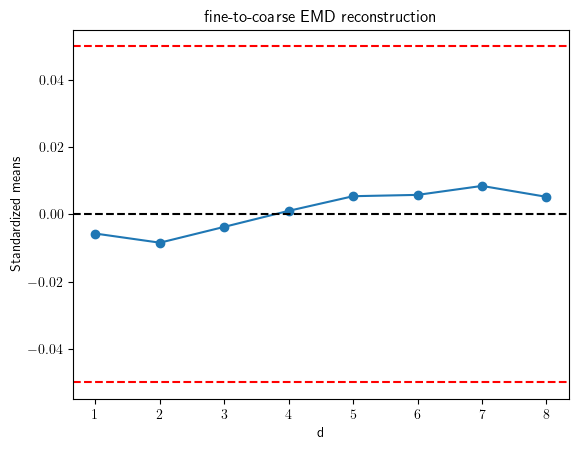

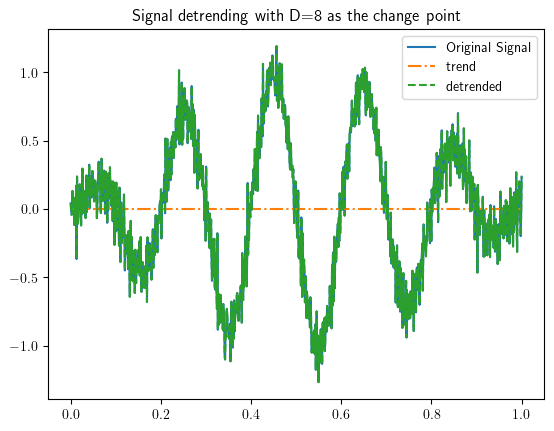

In [45]:
emd.detrend(T, S, imfs, residual, 0.05)

## Denoising 

Now we’re going to see the second method presented in the paper for denoising (a dual problem of detrending). Instead of keeping the IMFs with a low index, we keep the ones with a high index.

The IMFs of fGn follow a predictable energy distribution due to EMD’s behavior as a dyadic filter bank. The expected energy of the k-th IMF is modeled as:

$$W_H[k] = C_H \rho_H^{-2(1-H)k}, \quad k \geq 2$$

where:

•	$C_H = W_H[1] / \beta_H$,

•   $W_H[1] = \sum_{n=1}^N d_1^2[n]$ (We assume that the first IMF is noise-dominated)

•	$\rho_H \approx 2$ (empirically observed scaling factor),

•	$\beta_H$ is a scaling constant derived from simulations.
	
A confidence interval for the IMF energy is defined as:

$$T_H[k] = W_H[k] \cdot 2^{2^{a_H k + b_H}}$$

where $a_H$ and $b_H$ are parameters derived from simulation results for a chosen confidence level (e.g., 95% or 99%).

The energy of each IMF, $E_k = \sum_{n=1}^N d_k^2[n]$, is compared to the threshold $T_H[k]$. IMFs with $E_k > T_H[k]$ are considered “signal-dominated” and retained, while those with $E_k \leq T_H[k]$ are classified as “noise-dominated".

As we can see below, this method works much better than the detrending on this time serie. 

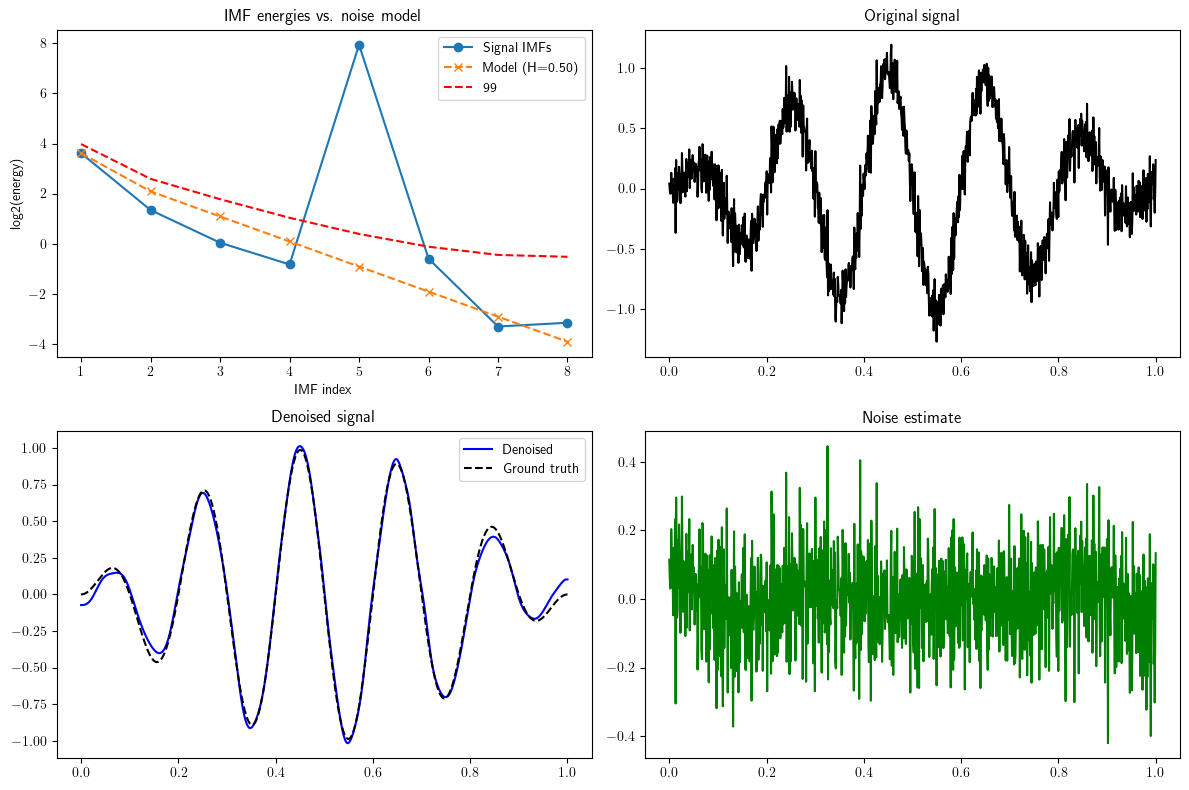

In [46]:
partial, noise_estimate = emd.denoise(T, S, imfs, residual, H=0.5, conf=0.99, ground_truth=S_original)

In the previous example, the denoising also works as intended.

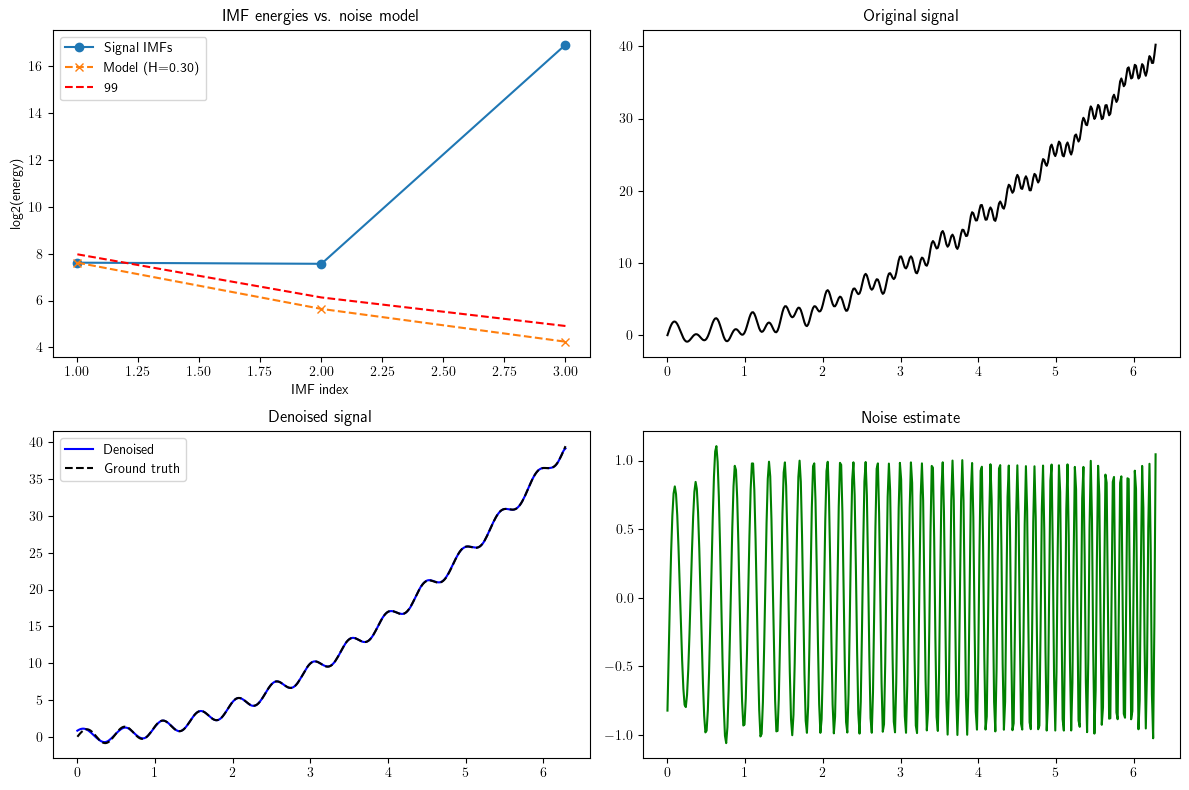

In [47]:
N = 400
T = np.linspace(0, 2*np.pi, N)
S_original = T**2 + np.sin(13 * T)
S = S_original + np.sin(20 * T * (1 + 0.2 * T))
imfs, residual = emd.decompose(S)
imfs, residual = emd.decompose(S)
partial, noise_estimate = emd.denoise(T, S, imfs, residual, H=0.3, conf=0.99, ground_truth=S_original)

### Degressive denoising
We also tried another denoising method, based on 
Degressive Denoising

We also tried another denoising method, based on this [report](https://dev.ipol.im/~morel/M%E9moires_Stage_Licence_2011/Maud%20Kerebel%2C%20Luc%20Pellissier%2C%20Daniel%20StanMemoire_EMD.pdf).

The idea is that some signal components may still be present in the first IMFs, which are typically dominated by high-frequency noise. This method retains every IMF but shrinks their amplitudes if their magnitude exceeds a certain threshold. The threshold for each IMF is computed based on its variance, with the thresholds progressively decreasing from the first IMF (highest-frequency noise) to the last IMF (lowest-frequency trend).

However, this approach is less effective on the current time series since the first IMF does not contain any meaningful signal. Nonetheless, it could prove useful for time series with nonlinearities, where signal components may overlap with high-frequency noise in the first few IMFs.

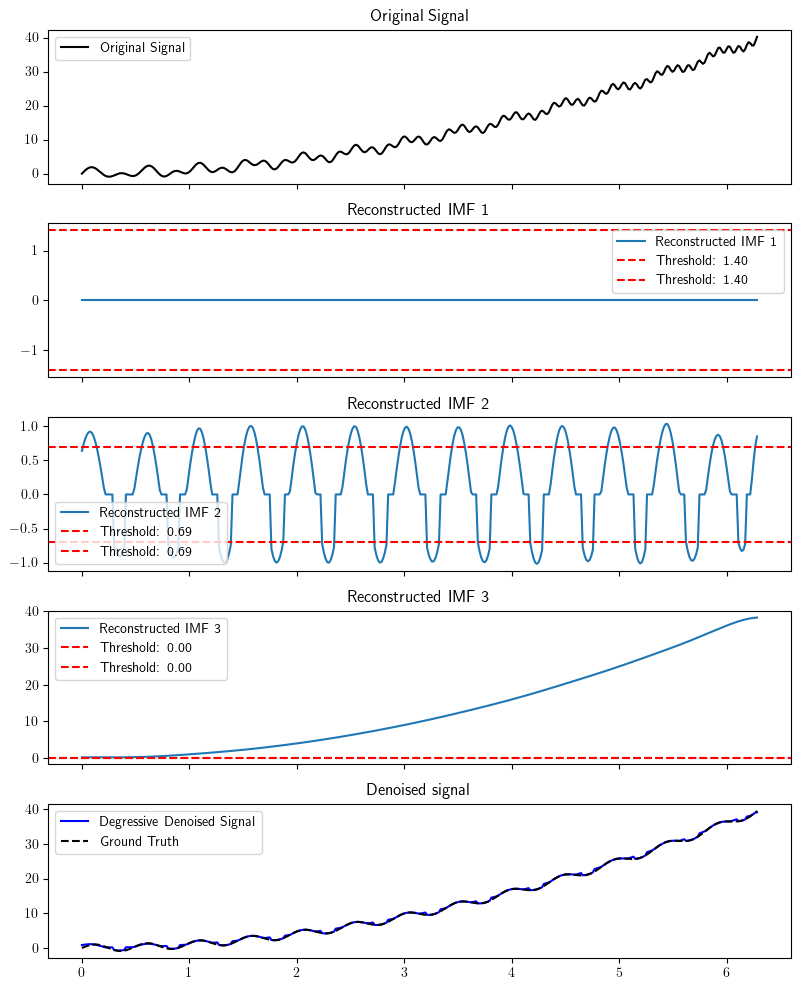

In [48]:
denoised, thresholds = emd.degressive_denoise(T, S, imfs, residual, ground_truth=S_original)

## EOG Classification 

We use the dataset `EOGHorizontalSignal` available at https://timeseriesclassification.com/description.php?Dataset=EOGHorizontalSignal.

We are going to artificially noise the dataset, and classify the signals with a DTW-based K-NN. 

We want to see if using the EMD to denoise the signal improves the accuracy.

In [18]:
def read(file_path):
    """
    Function to read the .ts files
    """
    data = []
    labels = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if not line.startswith('@') and not line.startswith('#'):
                features, label = line.split(':')
                features = [float(value) for value in features.split(',') if value]
                data.append(features)
                labels.append(int(label))

    return np.array(data), np.array(labels)

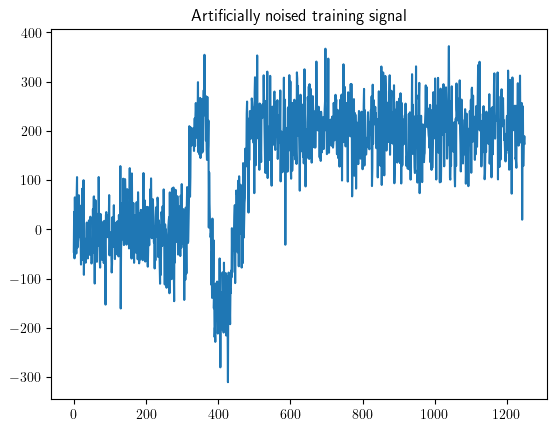

In [72]:
X_train_gt, y_train = read("EOGHorizontalSignal/EOGHorizontalSignal_TRAIN.ts")
X_test_gt, y_test = read("EOGHorizontalSignal/EOGHorizontalSignal_TEST.ts")

# We artificially noise the dataset.
np.random.seed(42)
X_train = X_train_gt + 0.5 * np.std(X_train_gt, axis=1, keepdims=True) * np.random.randn(*X_train_gt.shape)
X_test = X_test_gt + 0.5 * np.std(X_test_gt, axis=1, keepdims=True) * np.random.randn(*X_test_gt.shape)

plt.plot(X_train[60])
plt.title("Artificially noised training signal")
plt.show()

In [ ]:
!pip install tslearn

from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.metrics import accuracy_score

In [22]:
y_pred = KNeighborsTimeSeriesClassifier(metric="dtw", n_jobs=-1).fit(X_train, y_train).predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc)

Test accuracy: 0.43646408839779005


### Now, let's try to apply denoising before the K-NN.

First, let's find out what the Hurst exponent of the process is.

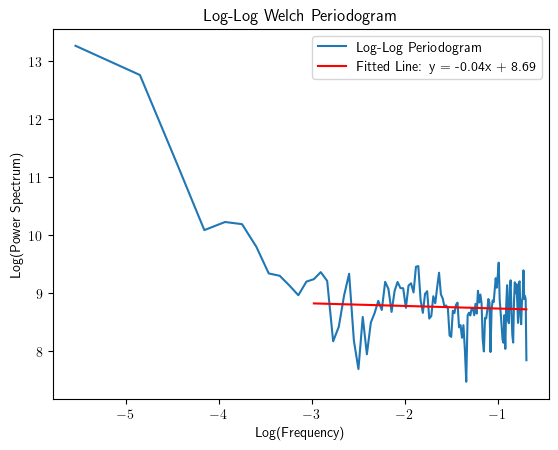

In [75]:
frequencies, power_spectrum = welch(X_train[40], fs=1, nperseg=256)
log_frequencies = np.log(frequencies[1:])
log_power_spectrum = np.log(power_spectrum[1:])

def affine_model(x, a, b):
    return a * x + b

mask = (log_frequencies >= -3) & (log_frequencies <= -0.5)
log_frequencies_filtered = log_frequencies[mask]
log_power_spectrum_filtered = log_power_spectrum[mask]
params_filtered, _ = curve_fit(affine_model, log_frequencies_filtered, log_power_spectrum_filtered)
slope_filtered, intercept_filtered = params_filtered
fitted_line_filtered = affine_model(log_frequencies_filtered, slope_filtered, intercept_filtered)

plt.plot(log_frequencies, log_power_spectrum, label="Log-Log Periodogram")
plt.plot(log_frequencies_filtered, fitted_line_filtered, label=f"Fitted Line: y = {slope_filtered:.2f}x + {intercept_filtered:.2f}", color="red")
plt.title("Log-Log Welch Periodogram ")
plt.xlabel("Log(Frequency)")
plt.ylabel("Log(Power Spectrum)")
plt.legend()
plt.show()

The log-log Welch spectrum suggest that a fGn model is qualitatively admissible in the mid-frequency range, with a slope of $0 \approx 2H - 1$, leading to $H \approx 0.5$, which is expected since we added white noise.

We thus applied the denoising method from the paper with $H=0.5$.

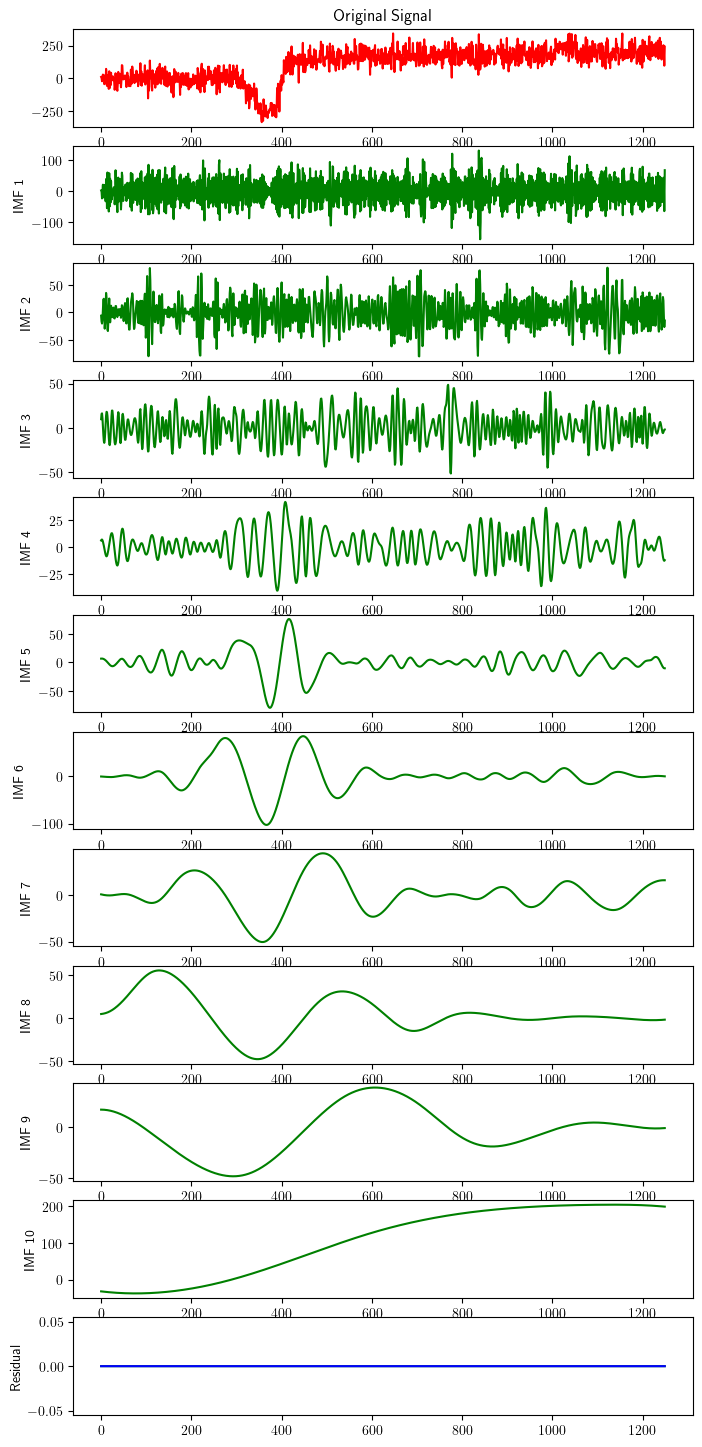

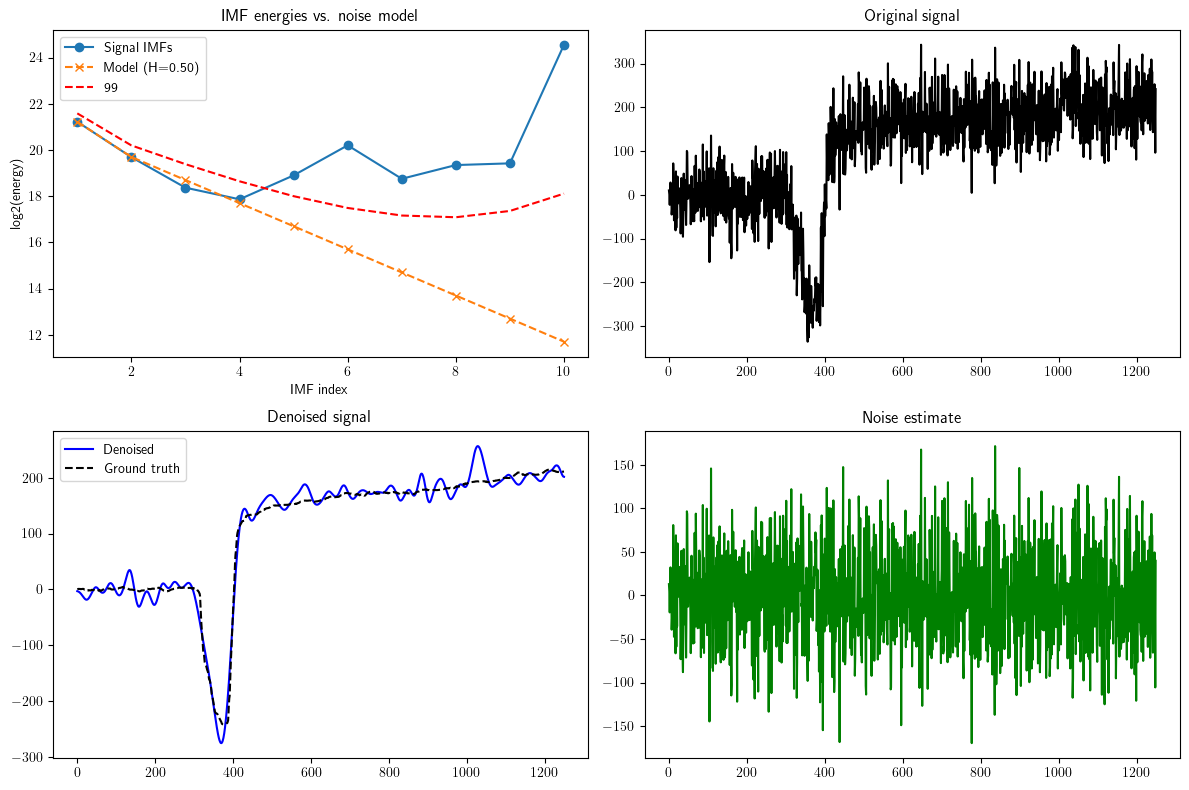

In [76]:
S = X_train[20]
T = np.arange(len(S))
imfs, residual = emd.decompose(S)
emd.plot_decomp(S, imfs, residual)
partial, noise_estimate = emd.denoise(T, S, imfs, residual, ground_truth=X_train_gt[20], H=0.5, conf=0.99)

In [23]:
def denoise(array):
    res = []
    for signal in array:
        S = signal.copy()
        T = np.arange(len(S))
        imfs, residual = emd.decompose(S)
        denoised, _ = emd.denoise(T, S, imfs=imfs, residual=residual, H=0.5, conf=0.99, plot=False)
        res.append(denoised)
    return np.array(res)

In [24]:
X_train_denoised = denoise(X_train)
X_test_denoised = denoise(X_test)

print("Denoised")

y_pred = KNeighborsTimeSeriesClassifier(metric="dtw", n_jobs=-1).fit(X_train_denoised, y_train).predict(X_test_denoised)
test_acc = accuracy_score(y_test, y_pred)
print("Test accuracy:", test_acc)

Denoised
Test accuracy: 0.43922651933701656


The results are a bit dissapointing, merely improving the accuracy.

Let's compare with usual denoising methods.

### Denoising with a low pass filter

The first method is to use the Additive white Gaussian noise (AWGN) model. 

The hypothesis are verified given how we simulated the noise.

Even though the time serie is clearly not stationary, we will still use the log DFT to find the optimal cut-off frequency.

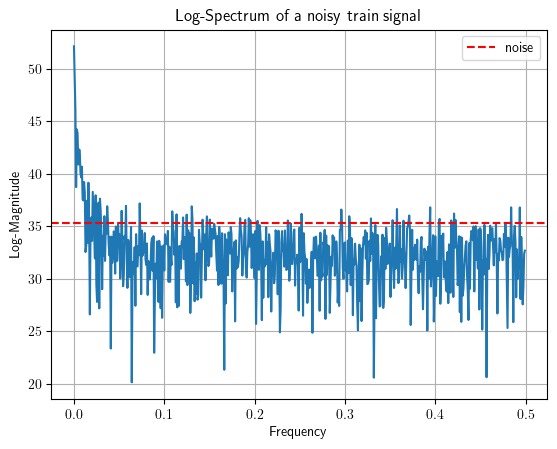

In [79]:
idx = 40
signal = X_train[idx]
fft_result = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal))
log_spectrum = 10 * np.log10(np.abs(fft_result))

std = 0.5 * np.std(X_train_gt[idx])
log_noise = 10 * np.log10(std**2)

plt.plot(freqs[:len(freqs)//2], log_spectrum[:len(log_spectrum)//2])
plt.axhline(y=log_noise, color='red', linestyle='--', label="noise")
plt.title("Log-Spectrum of a noisy train signal")
plt.xlabel("Frequency")
plt.ylabel("Log-Magnitude")
plt.grid()
plt.legend()
plt.show()

We will take the cut-off frequency as 0.03Hz.

In [25]:
def low_pass_filter(signal, cutoff=0.03, fs=1, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff)
    return filtfilt(b, a, signal)

In [26]:
def classic_denoise(array):
    res = []
    for signal in array:
        denoised_signal = low_pass_filter(signal)
        res.append(denoised_signal)
    return np.array(res)

In [27]:
# Apply classic denoising
X_train_classic_denoised = classic_denoise(X_train)
X_test_classic_denoised = classic_denoise(X_test)

print("Denoised")

y_pred_classic = KNeighborsTimeSeriesClassifier(metric="dtw", n_jobs=-1).fit(X_train_classic_denoised, y_train).predict(X_test_classic_denoised)
test_acc_classic = accuracy_score(y_test, y_pred_classic)
print("Test accuracy (Classic Denoising):", test_acc_classic)

Denoised
Test accuracy (Classic Denoising): 0.4558011049723757


### Denoising with wavelet transform

In [28]:
!pip install PyWavelets
import pywt

In [84]:
coeffs = pywt.wavedec(signal, "db4", level=4)
threshold = np.sqrt(2 * np.log(len(signal))) * np.std(coeffs[-1])
coeffs_denoised = [pywt.threshold(c, threshold, mode="soft") if i > 0 else c for i, c in enumerate(coeffs)]
denoised_signal = pywt.waverec(coeffs_denoised, "db4")

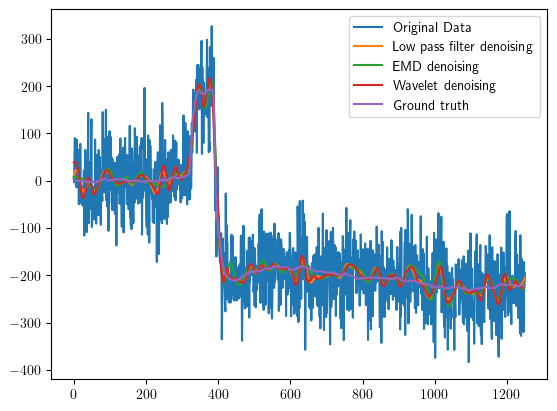

In [85]:
plt.plot(signal, label="Original Data")
plt.plot(low_pass_filter(signal), label="Low pass filter denoising")
emd = EMD()
imfs, residual = emd.decompose(signal)
plt.plot(emd.denoise(np.arange(len(signal)), signal, imfs=imfs, residual=residual, H=0.5, plot=False)[0], label="EMD denoising")
plt.plot(denoised_signal, label="Wavelet denoising")
plt.plot(X_train_gt[idx], label="Ground truth")
plt.legend()
plt.show()

In [29]:
def wavelet_denoise(array, wavelet="db4", level=4):
    res = []
    for signal in array:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        threshold = np.sqrt(2 * np.log(len(signal))) * np.std(coeffs[-1])
        coeffs_denoised = [pywt.threshold(c, threshold, mode="soft") if i > 0 else c for i, c in enumerate(coeffs)]
        denoised_signal = pywt.waverec(coeffs_denoised, wavelet)
        res.append(denoised_signal[:len(signal)])
    return np.array(res)

In [30]:
X_train_wavelet_denoised = wavelet_denoise(X_train)
X_test_wavelet_denoised = wavelet_denoise(X_test)

y_pred_wavelet = KNeighborsTimeSeriesClassifier(metric="dtw", n_jobs=-1).fit(X_train_wavelet_denoised, y_train).predict(X_test_wavelet_denoised)
test_acc_wavelet = accuracy_score(y_test, y_pred_wavelet)
print("Test accuracy (Wavelet Denoising):", test_acc_wavelet)

Test accuracy (Wavelet Denoising): 0.4696132596685083


The Wavelet transform denoising works better, which is expected because it's a method tailored to nonlinear and non-stationary time series, whereas a low-pass filter works best with stationary data. 

Our results are a bit disappointing. The EMD is supposed to work well on nonlinear and non-stationary time series, but it underperforms the loss-pass filter.

## Speech signal noise reduction by EMD

In this section, we apply Empirical Mode Decomposition (EMD) combined with a novel denoising method presented in the 2008 paper "Speech Signal Noise Reduction by EMD" by Boudraa, to speech signals with varying levels of noise. The results are then compared to those obtained using wavelet shrinkage.

In [88]:
# Helper functions

def SNR(clean_signal, corrupted_signal):
    signal_power = np.sum(clean_signal ** 2)
    noise_power = np.sum((corrupted_signal - clean_signal) ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def add_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    noise_power = signal_power / (10**(snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    return signal + noise

def denoise_wavelet(noisy_signal):
    coeffs = pywt.wavedec(noisy_signal, "db4", level=4)
    threshold = np.sqrt(2 * np.log(len(noisy_signal))) * np.std(coeffs[-1])
    coeffs_denoised = [pywt.threshold(c, threshold, mode="soft") if i > 0 else c for i, c in enumerate(coeffs)]
    denoised_signal = pywt.waverec(coeffs_denoised, "db4")
    return denoised_signal

def plot_audio_comparison(original, noisy, wavelet_denoised, emd_denoised, sr):
    t = np.linspace(0, len(original) / sr, len(original))
    plt.figure(figsize=(6, 5))
    
    plt.subplot(4, 1, 1)
    plt.plot(t, original, color='b')
    plt.title('Original Audio Signal')
    plt.ylabel('Amplitude')
    
    plt.subplot(4, 1, 2)
    plt.plot(t, noisy, color='orange')
    plt.title('Noisy Audio Signal')
    plt.ylabel('Amplitude')
    
    plt.subplot(4, 1, 3)
    plt.plot(t, wavelet_denoised, color='g')
    plt.title('Wavelet Denoised Signal')
    plt.ylabel('Amplitude')
    
    plt.subplot(4, 1, 4)
    plt.plot(t, emd_denoised, color='r')
    plt.title('EMD Denoised Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.show()

In [89]:
audio_path = "audio_samples/clean_1319.wav"
audio, sr = librosa.load(audio_path, sr=None)
ipd.Audio(audio, rate=sr)

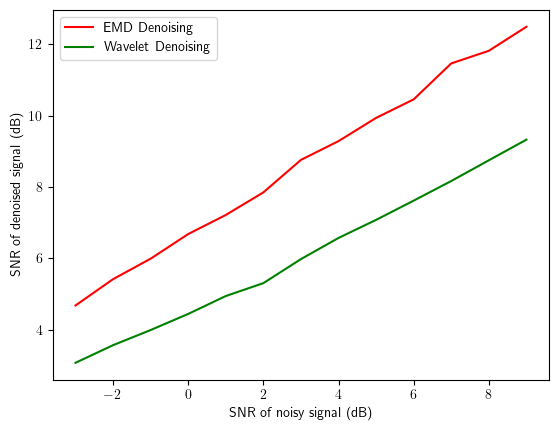

In [90]:
input_snr = np.arange(-3,10)
output_snr = []
output_snr_wavelet = []

emd = EMD()

for snr in input_snr:
    noisy_signal = add_noise(audio, snr)
    imfs, residual = emd.decompose(noisy_signal)
    denoised_emd_signal = emd.thresholdinf_denoise(noisy_signal, imfs, residual)
    output_snr.append(SNR(audio, denoised_emd_signal))
    denoised_wavelet_signal = denoise_wavelet(noisy_signal)
    output_snr_wavelet.append(SNR(audio, denoised_wavelet_signal))

plt.plot(input_snr, output_snr, color="r", label="EMD Denoising")
plt.plot(input_snr, output_snr_wavelet, color="g", label="Wavelet Denoising")
plt.xlabel('SNR of noisy signal (dB)')
plt.ylabel('SNR of denoised signal (dB)')
plt.legend(loc='best')

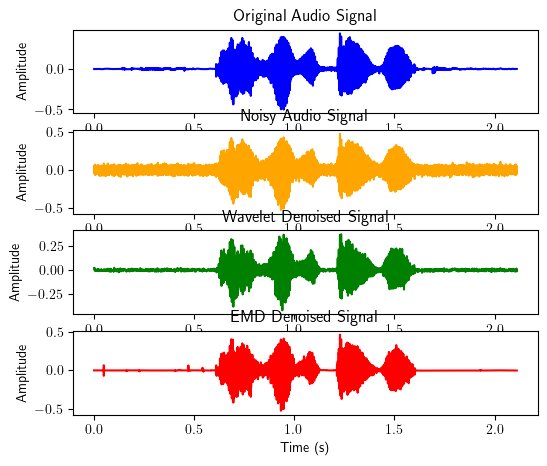

In [91]:
plot_audio_comparison(audio, noisy_signal, denoised_wavelet_signal, denoised_emd_signal, sr)

In [92]:
ipd.Audio(noisy_signal, rate=sr)

In [93]:
ipd.Audio(denoised_emd_signal, rate=sr)

In [94]:
ipd.Audio(denoised_wavelet_signal, rate=sr)

### Real noise

We try to apply this denoising method to a signal contaminated with real noise (the person is talking in a noisy environment).

In [95]:
id_audio = 100

audio_path = f"audio_samples/clean_{id_audio}.wav"
audio, sr = librosa.load(audio_path, sr=None)
print("Clean audio : ")
ipd.Audio(audio, rate=sr)

Clean audio : 


In [96]:
audio_path = f"audio_samples/noisy_{id_audio}.wav"
noisy_audio, sr = librosa.load(audio_path, sr=None)
print("Noisy audio : ")
ipd.Audio(noisy_audio, rate=sr)

Noisy audio : 


In [97]:
imfs, residual = emd.decompose(noisy_audio)
denoised_emd_signal = emd.thresholdinf_denoise(noisy_audio, imfs, residual)
print("Denoised audio : ")
ipd.Audio(denoised_emd_signal, rate=sr)

Denoised audio : 


The EMD hasn't filtered the background voice. 

In [98]:
print("SNR before denoising : ", SNR(noisy_audio, audio))
print("SNR after denoising : ", SNR(denoised_emd_signal, audio))

SNR before denoising :  5.137463212013245
SNR after denoising :  5.09475627143123


As expected, the SNR isn't better and the method doesn't work well for this type of noise contamination.